# Preparation

In [32]:
import rpy2
from rpy2.robjects.pandas2ri import py2rpy, rpy2py
rpy2.robjects.pandas2ri.activate()

In [33]:
#### Load in packages ####
# data management packages
import numpy as np
import pandas as pd
# date packages
from datetime import datetime
# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
# NLP packages
import re
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
# USE packages
import tensorflow_hub as hub
USE = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# tSNE packages
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

In [34]:
# if there's any errors with rpy2, disconnect and reconnect runtime
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import rpy2.robjects.packages as rpackages

pandas2ri.activate()

In [35]:
# uncomment the lines below to install
# utils = rpackages.importr('utils')
# utils.chooseCRANmirror(ind=1)
# utils.install_packages('tidyverse')
# utils.install_packages('lme4')
# utils.install_packages('lmerTest')
# utils.install_packages('emmeans')
# utils.install_packages('boot')
# utils.install_packages('stm')
# utils.install_packages('readxl')

(as ‘lib’ is unspecified)







	‘/tmp/RtmplL7lm6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmplL7lm6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmplL7lm6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmplL7lm6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmplL7lm6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmplL7lm6/downloaded_packages’

(as ‘lib’ is unspecified)







	‘/tmp/RtmplL7lm6/downloaded_packages’



<rpy2.rinterface_lib.sexp.NULLType object at 0x7e0a2abc3580> [RTYPES.NILSXP]

In [36]:
%load_ext rpy2.ipython


The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [37]:
%%R
library(tidyverse)
library(lme4)
library(lmerTest)
library(emmeans)
library(boot)
library(stm)
library(readxl)

In [38]:
#### Helper functions ####
def USE_similarity(USE, sentence1, sentence2):
    """
    Return the similarity as calculated in the universal sentence encoder
    between <sentence1> and <sentence2>. <USE> stands for an already-imported
    pretrained USE model.
    """
    USE_output = np.array(USE([sentence1, sentence2]))
    similarity = np.inner(USE_output[0], USE_output[1])
    return similarity

def ART_to_clause(ART):
    """
    Split ART into clauses
    """
    if type(ART) == type(''):
        # removed and, so, and as due to false positive rates
        split_by = ['.',',',':',';','?','!','\n',' - ',' -- ',' but ',' which ', ' if ', ' though ', ' until '
                         ' because ',' while ',' before ',' after ']
        ART = re.sub("[\(\[].*?[\)\]]", "", ART)
        for token in split_by:
            ART = ART.replace(token, '%>%')
        splitted = ART.split('%>%')
        result = []
        for i in range(len(splitted)):
            chunk = splitted[i].strip()
            if len(chunk) > 0:
                result.append(chunk)
        return result

def recombine_to_portion(text_clause, how='random'):
    """
    Return the recombined clause level segmentation into the portion level.
    <how> can be either 'balance' or 'random'. If 'balance', it would add to the middle portion when there is 1 odd
    sentence, and add to front and back when there are two odd sentences. If 'random', it would randomly assign odd
    sentences to one of each three portions
    """
    for i in range(len(text_clause)):
        text_clause[i] += ' '
    length = len(text_clause)
    portion_len = length // 3
    portion_res = length % 3
    start_len, mid_len, end_len = portion_len, portion_len, portion_len
    # when length is not even
    if how == 'balance':
        if portion_res == 1:
            mid_len += 1
        if portion_res == 2:
            start_len += 1
            end_len += 1
    elif how == 'random':
        to_add = np.random.choice([0,1,2], size=portion_res, replace=False)
        if 0 in to_add:
            start_len += 1
        if 1 in to_add:
            mid_len += 1
        if 2 in to_add:
            end_len += 1
    # assign ending indices
    start_index = start_len
    mid_index = start_len + mid_len
    # recombine segments
    start_lst = text_clause[:start_index]
    mid_lst = text_clause[start_index:mid_index]
    end_lst = text_clause[mid_index:]
    return ''.join(start_lst), ''.join(mid_lst), ''.join(end_lst)

def USE_similarity_portion(USE, sentence1, sentence2):
    """
    Return the similarity as calculated in the universal sentence encoder
    between the beginning, middle, and ending portion of <sentence1> and
    <sentence2>. The beginning of <sentence1> is always compared to the
    beginning of <sentence2> and not the other portions, and so on.
    """
    sentence1_portions = recombine_to_portion(ART_to_clause(sentence1))
    sentence2_portions = recombine_to_portion(ART_to_clause(sentence2))
    sim_start = USE_similarity(USE, sentence1_portions[0], sentence2_portions[0])
    sim_mid = USE_similarity(USE, sentence1_portions[1], sentence2_portions[1])
    sim_end = USE_similarity(USE, sentence1_portions[2], sentence2_portions[2])
    return sim_start, sim_mid, sim_end

In [39]:
%%R
semipartial_R2 = function(x) {
  require(lmerTest)
  x %>%
    anova(type = 3, ddf="Kenward-Roger") %>%
    as_tibble %>%
    mutate(R2 = round(((NumDF / DenDF) * `F value` )/(1 + (NumDF / DenDF) * `F value` ), 3)) %>%
    select(R2) %>%
    bind_cols(x %>% anova(type = 3, ddf="Kenward-Roger") %>% row.names %>% as_tibble %>% rename(effect = value)) %>%
    return
}
calculate_icc_lmer = function(x) {
  random_effects = data.frame(VarCorr(x))
  intercept_variance  = random_effects[random_effects$var1 == "(Intercept)", 'vcov'][1]
  residual_variance  = random_effects[random_effects$grp == "Residual", 'vcov']
  icc  = intercept_variance / (residual_variance + intercept_variance)
  return(icc)
}

In [42]:
#### Load in data ####
# read cleaned PPT
from google.colab import files
uploaded = files.upload()
# for the code to work, input two files: PPT_cleaned_final.xlsx, and ECDC_07072022.xlsx

Saving PPT_cleaned_final.xlsx to PPT_cleaned_final.xlsx


In [ ]:
uploaded = files.upload()

In [43]:
#### Load in data ####
df_no_excl = pd.read_excel('PPT_cleaned_final.xlsx')
df_combined_excl = df_no_excl[df_no_excl['Combined_Exclusions'] == 0].reset_index(drop=True)
df_w = df_combined_excl[df_combined_excl['PPT_Exclusions'] == 0].reset_index(drop=True)
df_covid = pd.read_excel('ECDC_07072022.xlsx')

In [44]:
#### converting date to numbers to fit in statistical models
# convert date to days since Jan 2020
df_w['days'] = np.nan
for index, row in df_w.iterrows():
    days = (row['date'] - datetime(2020,1,1)).days
    df_w.at[index, 'days'] = days
# convert date also to approximated months since Jan 2020
# In this way, all participants from the same survey is represented by the same month value. This is done because we didn't sample at the level of days, so including different days is
# more like a noise and we need to reduce resolution to match our sampling rate (which is in order of months)
Sn_2_months = {0:5.5, 2:6.5, 3:7.5, 4:10.5, 5:12.5, 6:15.5, 7:17.5, 8:20.5, 9:22.5}
Sn_2_months_text = {0:'May 2020', 2:'June 2020', 3:'July 2020', 4:'Oct 2020', 5:'Dec 2020', 6:'Mar 2021', 7:'May 2021', 8:'Aug 2021', 9:'Oct 2021'}
df_w['months'] = df_w['Sn'].map(Sn_2_months)
df_w['months_text'] = df_w['Sn'].map(Sn_2_months_text)
#### convert date to fit the baseline coding of latent growth curve ####
df_w['months_baseline'] = df_w['months'] - 5.5

In [45]:
df_w = df_w.drop(columns="n_surveys")
df_w = df_w.sort_values(['ptp','Sn'])
df_n_surveys = df_w[['ptp','date']].groupby('ptp').count().reset_index()
df_n_surveys.columns = ['ptp','n_surveys']
df_w = pd.merge(df_w, df_n_surveys, on='ptp')
regions_dict = {'Canada':'NA', 'New_Zealand':'OC', 'United_States_of_America':'NA', 'Australia':'OC',
       'United_Kingdom':'UK', 'Spain':'EU', 'Chile':'SA', 'Portugal':'EU', 'Netherlands':'EU',
       'Italy':'EU', 'Hungary':'EU', 'Finland':'EU', 'Poland':'EU', 'France':'EU', 'Greece':'EU',
       'Slovenia':'EU', 'Mexico':'NA', 'Estonia':'EU', 'Germany':'EU', 'Ireland':'EU', 'Belgium':'EU'}
df_w['region'] = df_w['country'].map(regions_dict)
df_w['gender'] = df_w['gender'].map({1:'male',2:'female',3:'gender_diverse'})

In [46]:
df = df_w.melt(id_vars=['ptp','ExternalReference','Sn','date','PPT_Order','n_surveys',
                        'age','gender','country','region','days','months','months_baseline','months_text'],
             value_vars=['collective','personal'], var_name='type', value_name='text')
df = df.sort_values(['ptp','Sn','type']).reset_index(drop=True)

In [47]:
df.head()

,ptp,ExternalReference,Sn,date,PPT_Order,n_surveys,age,gender,country,region,days,months,months_baseline,months_text,type,text
0,13,141158749.0,0,2020-05-07 05:25:50,collective/personal,7,60.0,male,Canada,NA,127.0,5.5,0.0,May 2020,collective,2020 marked a unique period in World History t...
1,13,141158749.0,0,2020-05-07 05:25:50,collective/personal,7,60.0,male,Canada,NA,127.0,5.5,0.0,May 2020,personal,The COVID-19 pandemic came at an interesting t...
2,13,141158749.0,2,2020-06-19 13:46:26,personal/collective,7,60.0,male,Canada,NA,170.0,6.5,1.0,June 2020,collective,2020 affected every country of the world. It ...
3,13,141158749.0,2,2020-06-19 13:46:26,personal/collective,7,60.0,male,Canada,NA,170.0,6.5,1.0,June 2020,personal,"2020 was an interesting year. I , along with ..."
4,13,141158749.0,3,2020-07-20 06:05:56,personal/collective,7,60.0,male,Canada,NA,201.0,7.5,2.0,July 2020,collective,COVID-19 occurred at a time where major world ...


In [48]:
df_w.head()

,ptp,ExternalReference,age,gender,country,Sn,date,Combined_Exclusions,PPT_Exclusions,PPT_Order,collective,personal,days,months,months_text,months_baseline,n_surveys,region
0,13,141158749.0,60.0,male,Canada,0,2020-05-07 05:25:50,0,0.0,collective/personal,2020 marked a unique period in World History t...,The COVID-19 pandemic came at an interesting t...,127.0,5.5,May 2020,0.0,7,NA
1,13,141158749.0,60.0,male,Canada,2,2020-06-19 13:46:26,0,0.0,personal/collective,2020 affected every country of the world. It ...,"2020 was an interesting year. I , along with ...",170.0,6.5,June 2020,1.0,7,NA
2,13,141158749.0,60.0,male,Canada,3,2020-07-20 06:05:56,0,0.0,personal/collective,COVID-19 occurred at a time where major world ...,COVID-19 started as far as I was concerned in ...,201.0,7.5,July 2020,2.0,7,NA
3,13,141158749.0,60.0,male,Canada,5,2020-12-17 02:56:10,0,0.0,collective/personal,In 2019 people in Wuhan China began to be infe...,I was like most people who were affected by th...,351.0,12.5,Dec 2020,7.0,7,NA
4,13,141158749.0,60.0,male,Canada,6,2021-03-20 05:51:30,0,0.0,collective/personal,"In late 2019, a COVID variant crossed from ani...",I was more fortunate than most during COVID be...,444.0,15.5,Mar 2021,10.0,7,NA


# Descriptive statistics

**TODO: check other large online studies and check what demographic are they reporting (check Dani Bassett UPenn, and also online autobio lifetime studies)**<br/>
https://static-content.springer.com/esm/art%3A10.1038%2Fs41467-022-32113-6/MediaObjects/41467_2022_32113_MOESM1_ESM.pdf

**Buddhika: put the excluded data for the non-time-sensitive analysis, and test if our findings generalize to another group of people (held-out generalization) <br/>
Donna: exploratory add-on**

### General participant information

In [49]:
df_ptp = df_w[['ptp','age','gender','n_surveys','country','region']]
df_ptp = df_ptp.groupby(['ptp','region','country','gender']).mean().reset_index()
# drop ptp304 because they moved region (from UK to EU)
# but ptp304 can be kept for region non-specific analyses
# ptp576 moved country within EU so s/he is not dropped
# no other participants moved country
df_ptp = df_ptp[df_ptp['ptp']!=304].reset_index(drop=True)
df_ptp.head()

,ptp,region,country,gender,age,n_surveys
0,13,NA,Canada,male,60.0,7.0
1,33,NA,Canada,female,30.0,9.0
2,51,OC,New_Zealand,female,43.0,5.0
3,100,NA,United_States_of_America,male,28.0,5.0
4,135,NA,Canada,female,41.0,7.0


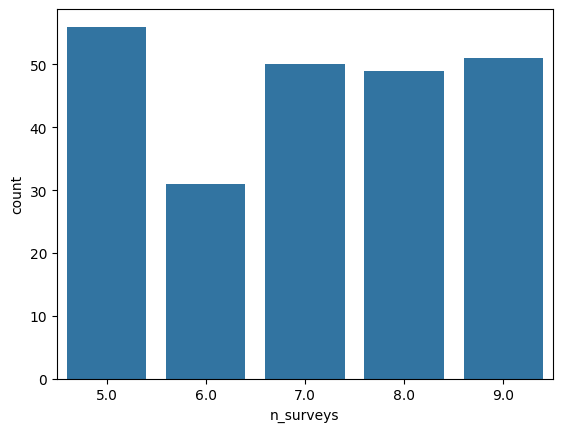

In [50]:
# note that these numbers are different from the ones in the preregistration document, because the
# numbers in the prereg were counted BEFORE any PPT specific exclusions, whereas the numbers here are AFTER those exclusions
df_n_surveys = pd.DataFrame(df_ptp['n_surveys'].value_counts()).reset_index()
df_n_surveys.columns = ['n_surveys','count']
sns.barplot(data=df_n_surveys, x='n_surveys',y='count')
plt.show()

In [51]:
len(df_ptp)

237

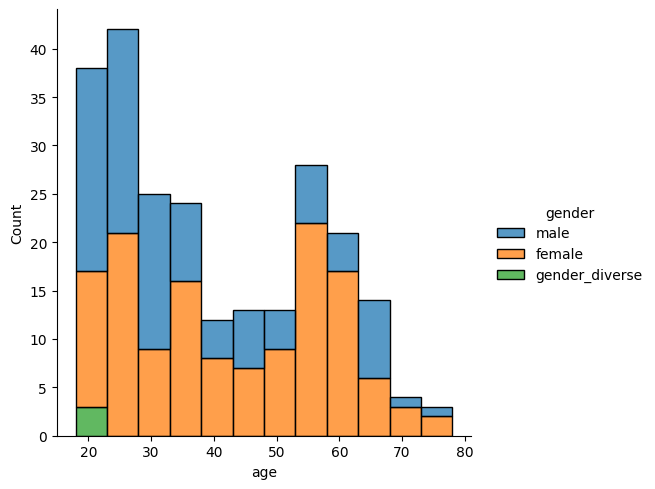

In [52]:
sns.displot(data=df_ptp, x='age', hue='gender', binwidth=5, multiple='stack')
plt.show()

In [53]:
min(df_ptp['age'])

18.0

In [54]:
max(df_ptp['age'])

78.0

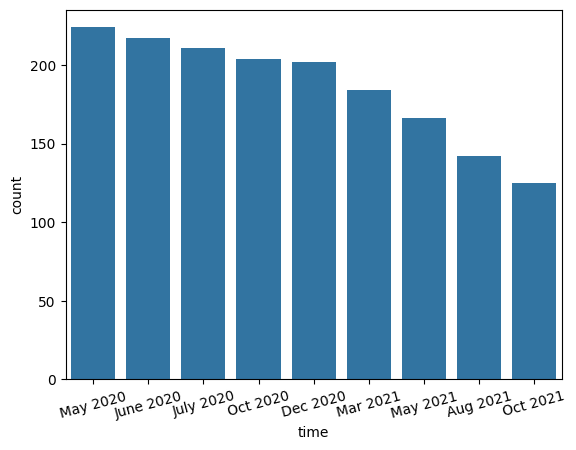

In [55]:
df_attrition = pd.DataFrame(df_w['months_text'].value_counts()).reset_index()
df_attrition.columns = ['time','count']
sns.barplot(data=df_attrition, x='time',y='count')
plt.xticks(rotation=15)
plt.show()

### Order of presentation effect

In [56]:
df_w['PPT_Order'].value_counts()

PPT_Order
personal/collective    841
collective/personal    834
Name: count, dtype: int64

<Axes: xlabel='PPT_Order', ylabel='PPT_Exclusions'>

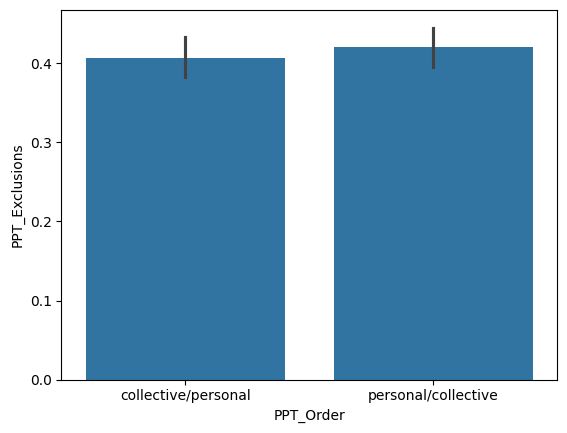

In [57]:
# We will also test if within-subject collective-personal similarity differs by PPT order with Q3
sns.barplot(data=df_combined_excl, x="PPT_Order", y="PPT_Exclusions")

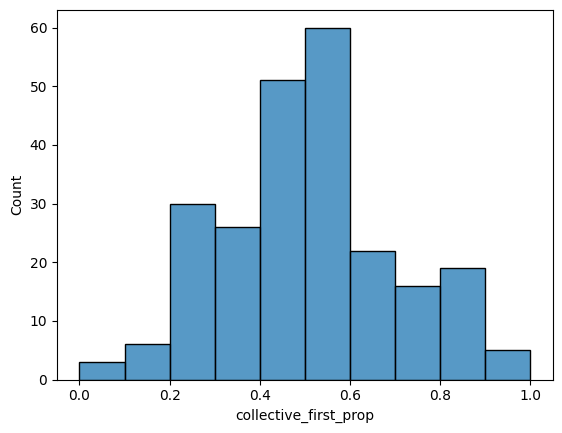

In [58]:
df_PPT_order = df_w[['ptp','PPT_Order','days']].groupby(['ptp','PPT_Order']).count().reset_index()
df_PPT_order = df_PPT_order.pivot(index='ptp', columns='PPT_Order', values='days').reset_index()
df_PPT_order = df_PPT_order.fillna(0)
df_PPT_order['collective_first_prop'] = df_PPT_order['collective/personal']\
    / (df_PPT_order['collective/personal'] + df_PPT_order['personal/collective'])
sns.histplot(data=df_PPT_order, x='collective_first_prop', bins=10)
plt.show()

### Regional effect

In [59]:
countries = list(regions_dict.keys())
country_names_ECDC = {'New Zealand':'New_Zealand', 'United States Of America':'United_States_of_America',
                      'United Kingdom':'United_Kingdom'}
df_covid['country'] = df_covid['country'].replace(country_names_ECDC)
df_covid['region'] = df_covid['country'].map(regions_dict)
for i in range(len(countries)):
    if countries[i] in country_names_ECDC.keys():
        countries[i] = country_names_ECDC[countries[i]]

df_covid = df_covid[df_covid['country'].isin(countries)]
df_covid['year'], df_covid['week'], df_covid['weeks_since_2020'] = np.nan, np.nan, np.nan
for index, row in df_covid.iterrows():
    year = int(row['year_week'].split('-')[0])
    week = int(row['year_week'].split('-')[1])
    df_covid.at[index, 'year'] = year
    df_covid.at[index, 'week'] = week
    df_covid.at[index, 'weeks_since_2020'] = 53*(year-2020) + week
df_covid = df_covid[df_covid['year'] != 2022].reset_index(drop=True)

<ipython-input-59-8eb907311cee>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_covid['year'], df_covid['week'], df_covid['weeks_since_2020'] = np.nan, np.nan, np.nan


In [60]:
df_covid.head()

,country,country_code,continent,population,indicator,weekly_count,year_week,rate_14_day,cumulative_count,source,note,region,year,week,weeks_since_2020
0,Australia,AUS,Oceania,25499881,cases,0.0,2020-01,NaN,0.0,Epidemic intelligence national data,NaN,OC,2020.0,1.0,1.0
1,Australia,AUS,Oceania,25499881,cases,0.0,2020-02,0.000000,0.0,Epidemic intelligence national data,NaN,OC,2020.0,2.0,2.0
2,Australia,AUS,Oceania,25499881,cases,0.0,2020-03,0.000000,0.0,Epidemic intelligence national data,NaN,OC,2020.0,3.0,3.0
3,Australia,AUS,Oceania,25499881,cases,4.0,2020-04,0.015686,4.0,Epidemic intelligence national data,NaN,OC,2020.0,4.0,4.0
4,Australia,AUS,Oceania,25499881,cases,7.0,2020-05,0.043137,11.0,Epidemic intelligence national data,NaN,OC,2020.0,5.0,5.0


In [61]:
fig = px.line(df_covid[df_covid['indicator']=='deaths'], x='weeks_since_2020', y='cumulative_count',
                 color='region', hover_data=['country'])
fig.show()

In [62]:
fig = px.line(df_covid[df_covid['indicator']=='deaths'], x='weeks_since_2020', y='rate_14_day',
                 color='region', hover_data=['country'])
fig.show()

In [63]:
df_ptp['region'].value_counts()
# UK pulled out because it's an island (as opposed to a continent)
# ok to include mexico as NA
# when doing regional analysis, still check that mexico does not form its own cluster away from US and CA
# use pandemic severeness time course as a justification for the region (so not just geographical)
# get pandemic case, severity, and response for each country and region (thick line for each region, thin line for each country)
# can have a final justification based on geographical population density if the pandemic thing didn't work out

region
UK    101
EU     75
NA     52
SA      6
OC      3
Name: count, dtype: int64

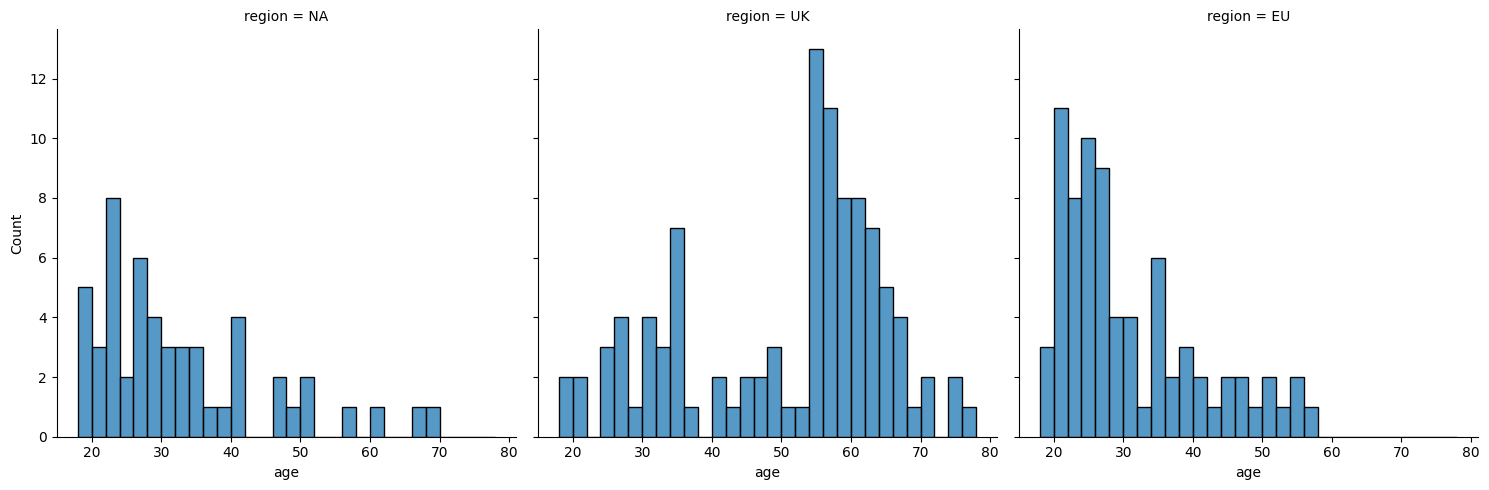

In [64]:
# when getting region effect maybe exclude some OA in UK to have to more comparable age
df_ptp_region = df_ptp[df_ptp['region'].isin(['UK','EU','NA'])].reset_index(drop=True)
sns.displot(data=df_ptp_region, x='age', col='region', binwidth=2)
plt.show()

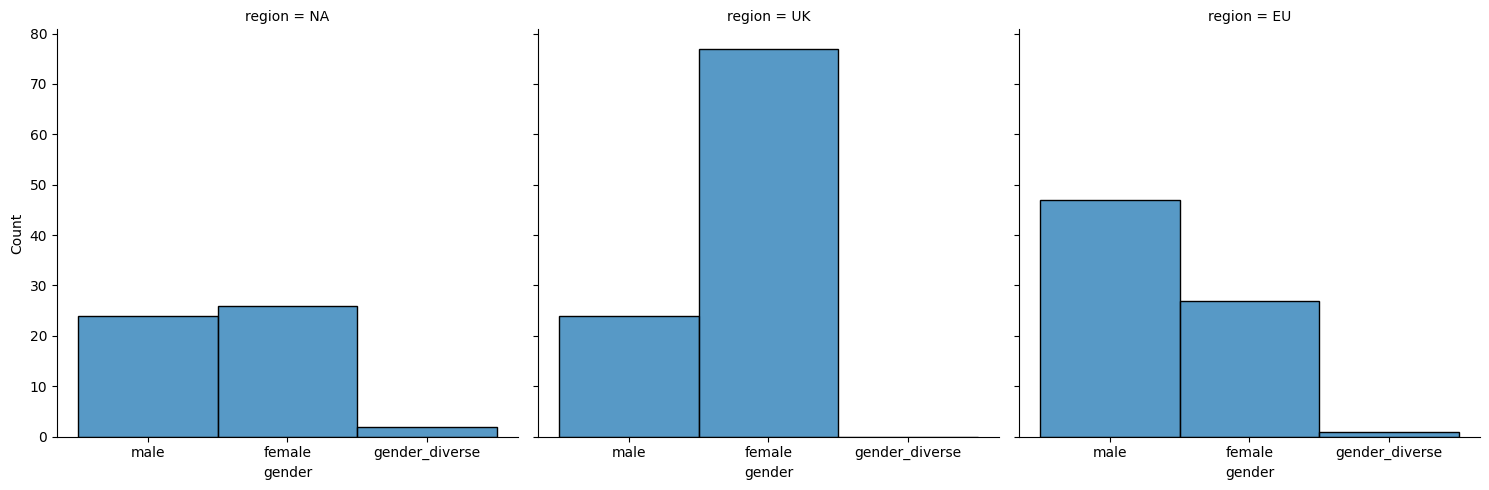

In [65]:
sns.displot(data=df_ptp_region, x='gender', col='region', binwidth=0.9)
plt.show()

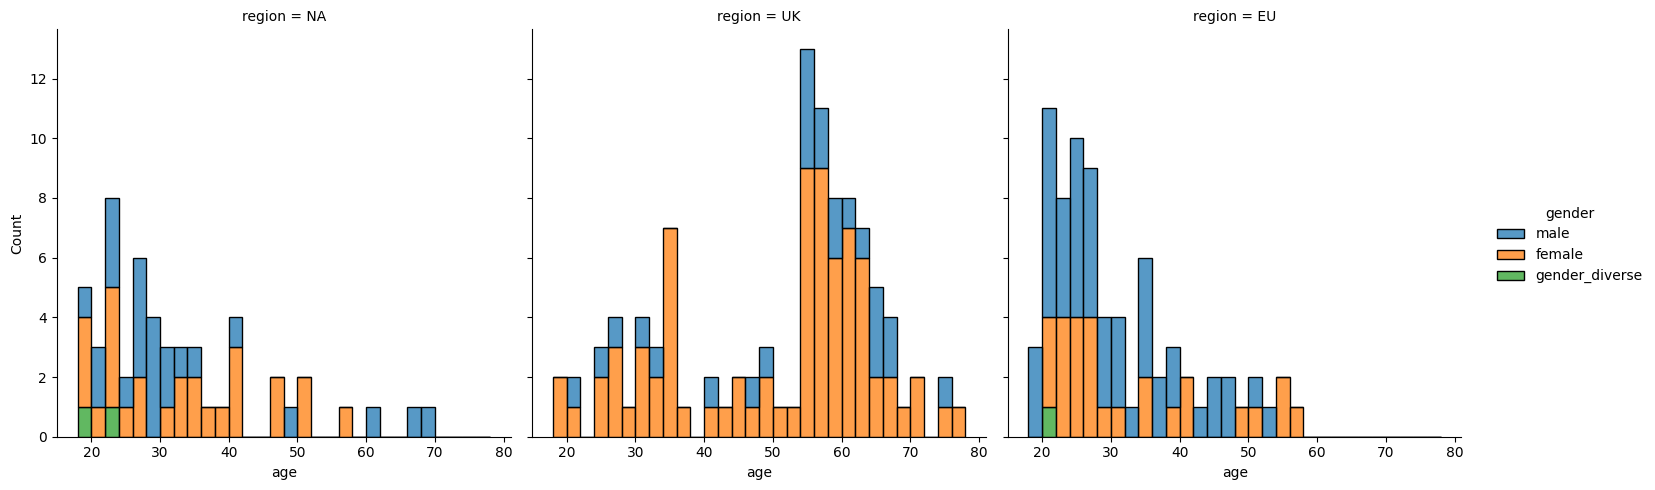

In [66]:
sns.displot(data=df_ptp_region, x='age', col='region', hue='gender', binwidth=2, multiple='stack')
plt.show()

### Narrative length
Note: reviewer might say that our narratives are longer (40 words is a common standard for USE; citation needed)

In [67]:
df['word_length'] = df['text'].apply(lambda x: len(tokenizer.tokenize(x)))

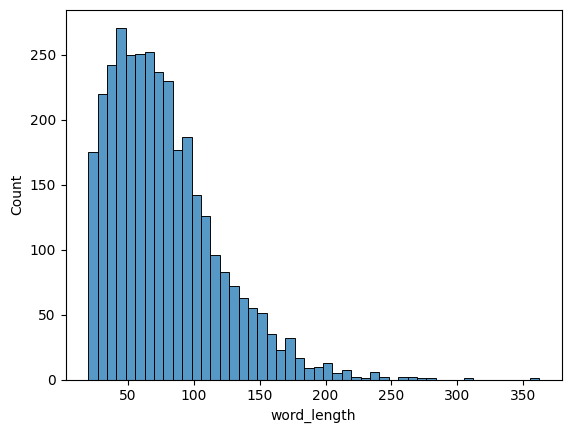

In [68]:
sns.histplot(data=df, x='word_length')
plt.show()

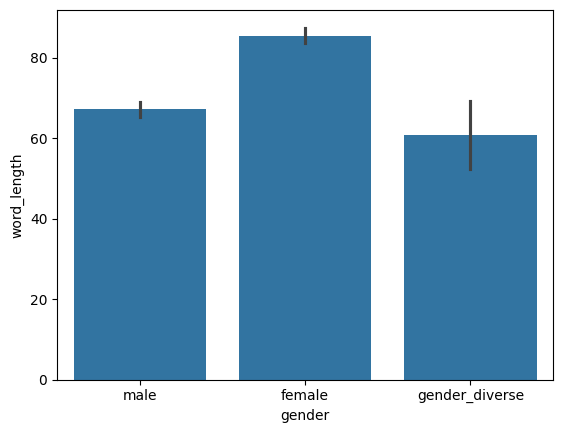

In [69]:
sns.barplot(data=df, x='gender', y='word_length')
plt.show()

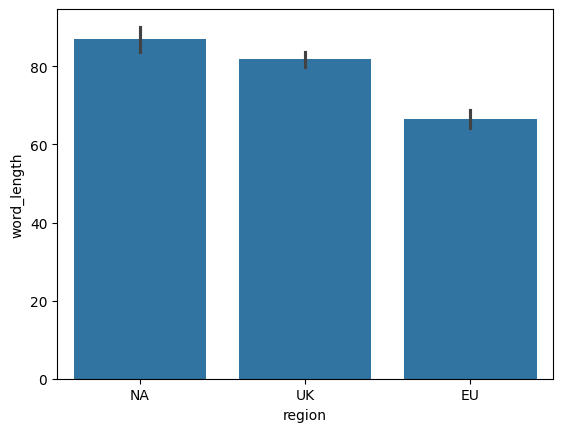

In [70]:
sns.barplot(data=df[df['region'].isin(['NA','UK','EU'])], x='region', y='word_length')
plt.show()

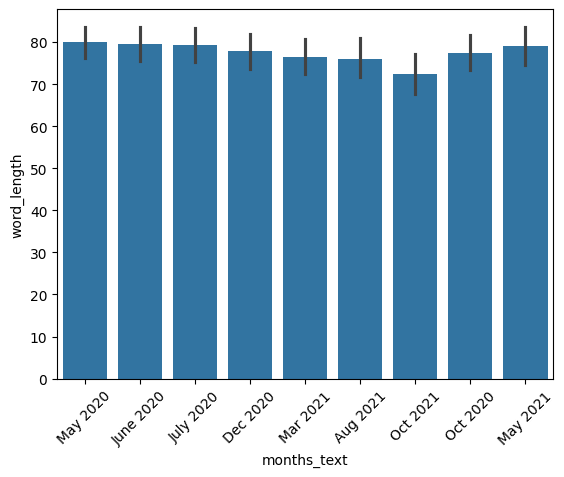

In [71]:
sns.barplot(data=df, x='months_text', y='word_length')
plt.xticks(rotation = 45)
plt.show()

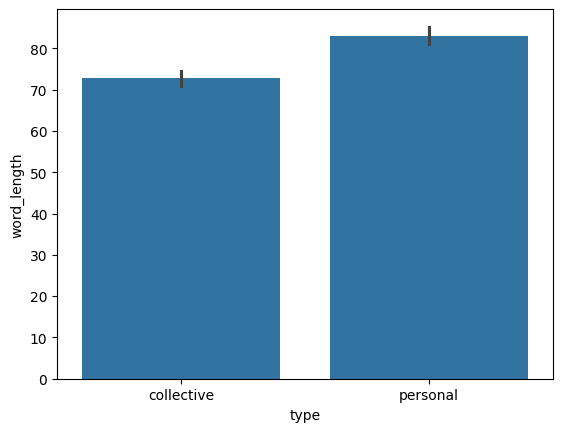

In [72]:
sns.barplot(data=df, x='type', y='word_length')
plt.show()

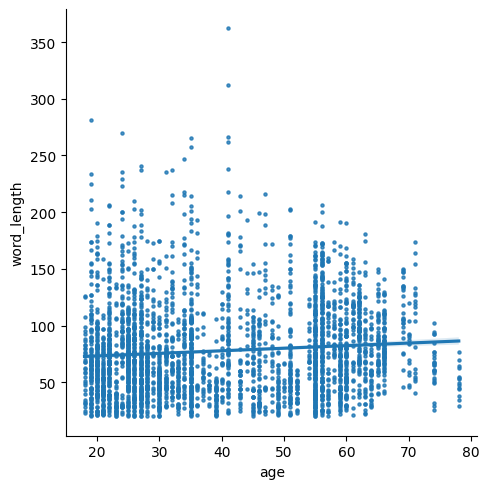

In [73]:
sns.lmplot(data=df, x='age', y='word_length', scatter_kws={"s": 5})
plt.show()

In [74]:
df.to_excel('df.xlsx')

In [75]:
%%R
df <- read_excel('df.xlsx')
age_length_model <- df %>%
  lmer(word_length ~ (1|ptp) + age, na.action = "na.exclude", data = .)
age_length_model

New names:
• `` -> `...1`
Linear mixed model fit by REML ['lmerModLmerTest']
Formula: word_length ~ (1 | ptp) + age
   Data: .
REML criterion at convergence: 32232.66
Random effects:
 Groups   Name        Std.Dev.
 ptp      (Intercept) 31.62   
 Residual             26.72   
Number of obs: 3350, groups:  ptp, 238
Fixed Effects:
(Intercept)          age  
    68.4283       0.2102  


# Question 1: Does the topical content of people’s personal and collective narratives differ?
**Hypothesis 1**: We expect personal narratives to contain more self-related topics, and collective narratives to contain more public-related topics. <br>
**Analysis 1**: We will run STM on the entire corpus to identify the most prevalent topics, and then conduct regression (stm package in R; Roberts et al., 2019) on the frequencies of these topics in each narrative, with narrative type as the predictor.

In [ ]:
df.to_csv('dataset.csv')
# continue to R

# Question 2: Over time, does a collective pandemic narrative emerge while personal pandemic narratives become more idiosyncratic?
**Hypothesis 2a**: Inter-personal (between-subjects) similarity will be higher for collective than personal narratives. <br>
**Hypothesis 2b**: Inter-personal similarity of collective narratives will increase over time, while that of personal narratives may decrease over time. <br>
**Analysis 2ab**: Using pairwise cosine inter-personal similarity (calculated across participants within the narrative type and timepoint), we will construct a crossed random effects model, with narrative type and time as the fixed effects, and pairs of participants being compared with each other as the crossed random effects. We will calculate the main effect of narrative type to test hypothesis 2a, and its interaction with time to test hypothesis 2b.

**Hypothesis 2c**: Inter-personal similarity metrics for participants belonging to the same “community” (as measured by participants’ shared geographical region, shared COVID-19 experiences, or both) will be higher overall and increase more rapidly over time than for participants in different communities.<br>
**Analysis 2c**: We will re-compute Analysis 2ab, nesting participants according to community and testing the importance of shared communities using permutation testing. Additionally, we will compute the pairwise similarities between narratives generated by participants in the same vs. different geographical regions.

# Question 3: Do an individual’s representations of their personal and collective narratives become more similar over time?
**Hypothesis 3**: Intra-personal (within-subject) similarity of personal and collective narratives will increase over time. <br>
**Analysis 3**: Using pairwise cosine intra-personal similarity (calculated across narrative time but within participants and within timepoint), we will construct a linear mixed effects model, with time as the fixed effect, and participant as the random effect.

**Note**<br>
1. USE acc drop off with longer text (look for citation), use this to justify the start, mid, end separation
1. We have 9 measurements per group (i.e. participant), so we can have 8 random coefficients at most. Some participants have done only 5 measurements, but it's ok because that's considered missing data and can be filled with LME

In [ ]:
#### Calculate within-subject similarity of personal and collective narratives
df3 = df_w.copy()
df3['sim'] = np.nan
df3['sim_start'] = np.nan
df3['sim_mid'] = np.nan
df3['sim_end'] = np.nan
for index, row in df3.iterrows():
    similarity = USE_similarity(USE, row['collective'], row['personal'])
    sim_start, sim_mid, sim_end = USE_similarity_portion(USE, row['collective'], row['personal'])
    df3.at[index, 'sim'] = similarity
    df3.at[index, 'sim_start'] = sim_start
    df3.at[index, 'sim_mid'] = sim_mid
    df3.at[index, 'sim_end'] = sim_end
df3.head()
df3.to_excel('USE_withinsubject_withintime.xlsx')

In [ ]:
df3_l = df3.melt(id_vars=['ptp','age','gender','Sn','days','months','months_text','months_baseline','region','sim'],
                 value_vars=['sim_start','sim_mid','sim_end'], var_name='portion',value_name='sim_portion')
df3_l.head()

,ptp,age,gender,Sn,days,months,months_text,months_baseline,region,sim,portion,sim_portion
0,13,60.0,male,0,127.0,5.5,May 2020,0.0,NA,0.209472,sim_start,0.111469
1,13,60.0,male,2,170.0,6.5,June 2020,1.0,NA,0.369730,sim_start,0.228624
2,13,60.0,male,3,201.0,7.5,July 2020,2.0,NA,0.362157,sim_start,0.138863
3,13,60.0,male,5,351.0,12.5,Dec 2020,7.0,NA,0.313278,sim_start,0.130180
4,13,60.0,male,6,444.0,15.5,Mar 2021,10.0,NA,0.323286,sim_start,0.022759


we could also run a supplimentary model with survey number as an ordinal variable

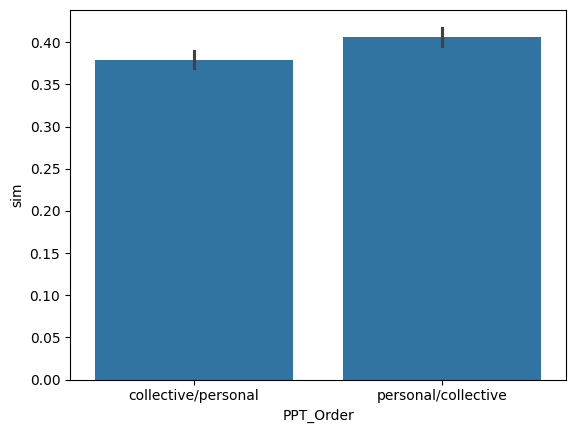

In [ ]:
sns.barplot(data=df3, x='PPT_Order', y='sim')
plt.show()

In [ ]:
%%R -i df3
df3_order_test <- df3 %>%
  pivot_wider(names_from=PPT_Order, values_from=sim)
print(t.test(df3_order_test$`collective/personal`, df3_order_test$`personal/collective`))

UsageError: Cell magic `%%R` not found.


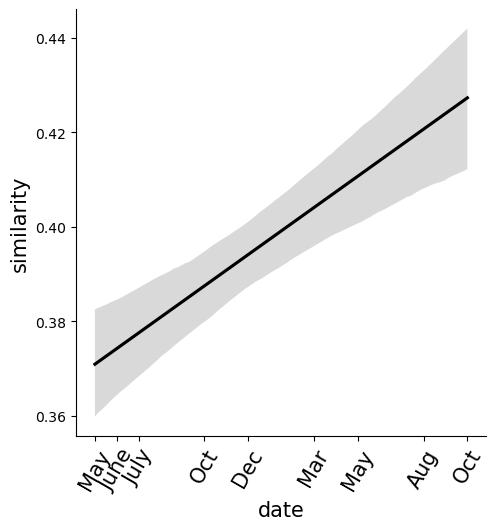

In [ ]:
#### Plot the change of within-subject similarity of personal and collective narratives over time
# plot days as the number of days since Jan 1, 2020
fontsize=15
sns.lmplot(data=df3, x='months', y='sim', scatter_kws={"s": 5,"alpha": 0.1,'color':'black'}, line_kws={'color':'black'}, scatter=False)
plt.ylabel('similarity', fontsize=fontsize)
plt.xlabel('date', fontsize=fontsize)
plt.xticks([5.5,6.5,7.5,10.5,12.5,15.5,17.5,20.5,22.5], ['May','June','July','Oct','Dec','Mar','May','Aug','Oct'], rotation=60, fontsize=fontsize)
plt.savefig('graphs/q3_USEsim_noscatter.pdf', bbox_inches='tight')
plt.show()

In [ ]:
%%R -i df3
df3 <- df3 %>%
  # convert ptp to factor
  mutate(across(all_of(c('ptp')), factor)) %>%
  group_by(ptp) %>%
  # mean centre similarity
  # this allows the model to converge, and also makes conceptual sense because we care about the progression of similarities over time, not the baseline individual difference
  mutate(sim = sim - mean(sim, na.rm = TRUE)) %>%
  ungroup()

model3 <- df3 %>%
  lmer(sim ~ (1+months_baseline|ptp) + months_baseline, na.action = "na.exclude", data = .)
print(summary(model3))
print('R2: showing the amount of variance that the current model explains')
print(semipartial_R2(model3))
print('ICC: how dependent observations within a group are on each other, random effects should be modeled if ICC > 0.1')
print(calculate_icc_lmer(model3))

UsageError: Cell magic `%%R` not found.


In [ ]:
%%R
qqnorm(resid(model3))
qqline(resid(model3))
# look for some threshold to determine normality

In [ ]:
%%R
# calculate the confidence interval of the main effect using bootstrapping
boot_function = function(data, indices) {
  boot_model = data[indices,] %>%
    lmer(sim ~ (1+months_baseline|ptp) + months_baseline, na.action = "na.exclude", data = .)
  return(boot_model %>% fixef)
}
set.seed(2022)
bootstrapped_model = df3 %>% boot(statistic=boot_function, R=50)
print(bootstrapped_model$t0)
print(bootstrapped_model %>% boot.ci(index = 2, type = "perc"))

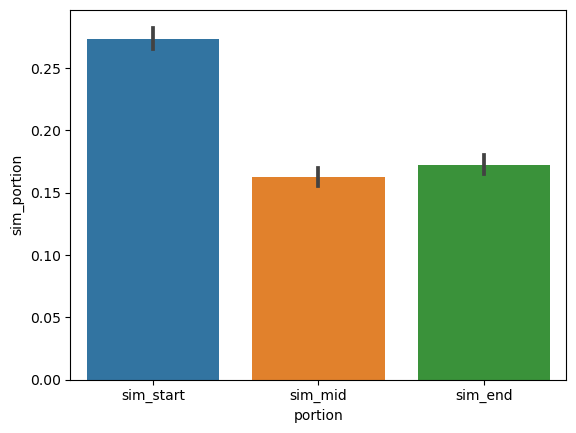

In [ ]:
sns.barplot(data=df3_l, x='portion',y='sim_portion')
plt.show()

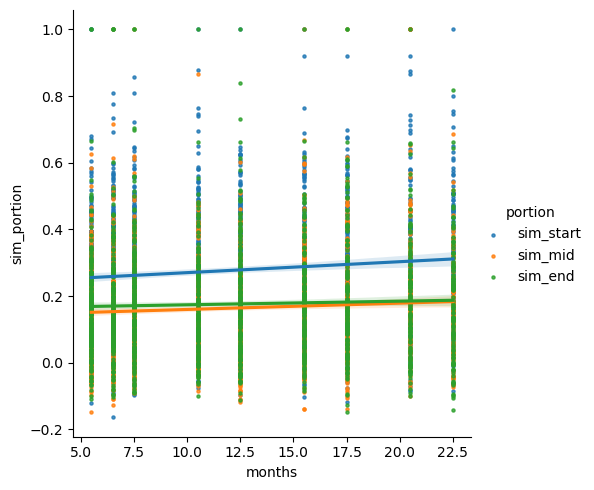

In [ ]:
sns.lmplot(data=df3_l, x='months', y='sim_portion', hue='portion', scatter_kws={"s": 5})
plt.show()

In [ ]:
%%R -i df3_l
df3_l <- df3_l %>%
  # convert ptp to factor
  mutate(across(all_of(c('ptp')), factor)) %>%
  group_by(ptp) %>%
  # mean centre similarity
  # this allows the model to converge, and also makes conceptual sense because we care about the progression of similarities over time, not the baseline individual difference
  mutate(sim_portion = sim_portion - mean(sim_portion, na.rm = TRUE)) %>%
  ungroup()

model3b <- df3_l %>%
  lmer(sim_portion ~ (1+months_baseline|ptp) + portion * months_baseline, na.action = "na.exclude", data = .)
print(summary(model3b))
print('R2: showing the amount of variance that the current model explains')
print(semipartial_R2(model3b))
print('ICC: how dependent observations within a group are on each other, random effects should be modeled if ICC > 0.1')
print(calculate_icc_lmer(model3b))

In [ ]:
%%R
qqnorm(resid(model3b))
qqline(resid(model3b))
# normality paper: lingering paper (Buddhika, 2022)
# maybe use non-normal parametric tests

In [ ]:
USE_array = np.zeros((len(df), 512))
for index, row in df.iterrows():
    text = row['text']
    USE_vector = np.array(USE([text]))
    USE_array[index,:] = USE_vector

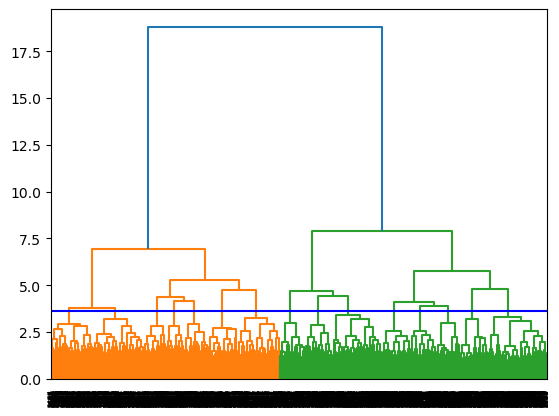

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage
linkage_data = linkage(USE_array, method='ward', metric='euclidean')
dendrogram(linkage_data)
plt.axhline(y=3.6, color='blue', linestyle='-')
plt.show()
# 15 clusters

In [ ]:
kmeans = KMeans(n_clusters=15).fit(USE_array)
kmeans_cluster = list(kmeans.labels_)
df['kmeans'] = kmeans_cluster

In [ ]:
pca = PCA(n_components=50)
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
pca_result = pca.fit_transform(USE_array)
pca_tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
pca_tsne_results = tsne.fit_transform(pca_result)
df['pca-tsne1'] = pca_tsne_results[:,0]
df['pca-tsne2'] = pca_tsne_results[:,1]

D:\Program\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\Program\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [ ]:
def plot_USE(df, hue_type):
    df['kmeans'] = df['kmeans'].astype("string")
    fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(10,5))
    x = f'pca-tsne1'
    y = f'pca-tsne2'
    Sn_list = [0,2,3,4,5,6,7,8,9]
    for i in range(9):
        axes_x = i // 5
        axes_y = i % 5
        Sn = Sn_list[i]
        df_sub = df[df['Sn'] == Sn]
        sns.scatterplot(ax=axes[axes_x, axes_y],x=x, y=y,hue=hue_type,data=df_sub,legend=False,alpha=0.3,size=0.1)
        axes[axes_x, axes_y].set_title(f'S{Sn}')
        axes[axes_x, axes_y].set_xlim(-10,10)
        axes[axes_x, axes_y].set_ylim(-15,15)
        axes[axes_x, axes_y].axis('off')
    axes[1,4].axis('off')
    plt.show()

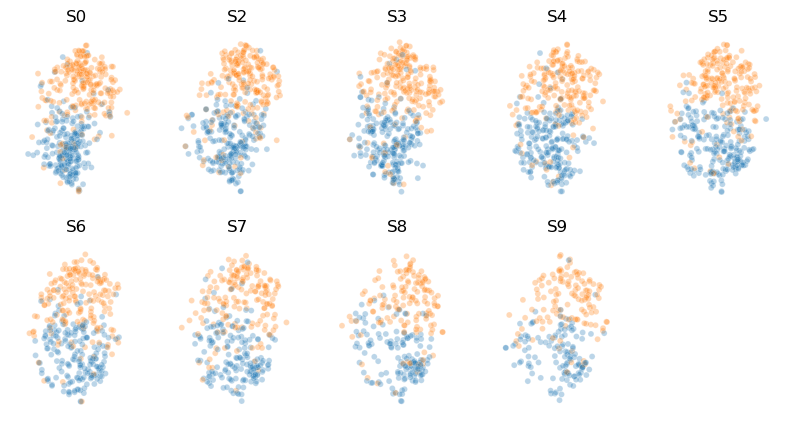

In [ ]:
plot_USE(df, "type")

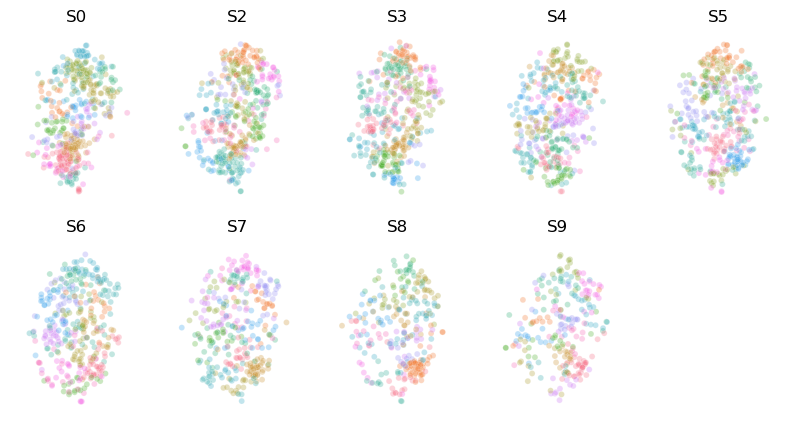

In [ ]:
plot_USE(df, "kmeans")

In [ ]:
df['kmeans'] = pd.to_numeric(df['kmeans'])
df.groupby(['type','kmeans']).count()['text'].unstack()

kmeans,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
type,,,,,,,,,,,,,,,
collective,73,191,166,14,214,158,254,156,9,15,178,99,8,8,132
personal,112,28,20,174,24,22,18,64,234,231,33,119,283,216,97


# Question 4: Does an individual’s narrative representation of the pandemic stabilize over time? Does this process differ for personal vs. collective narratives?
**Hypothesis 4a**: Intra-personal (within-subject) similarities between two temporally adjacent narratives (of the same type) will each increase over time (e.g., the similarity between personal narratives in March and May 2021 should be higher than for narratives in March and May 2020), reflecting the stabilization of the representation of the narrative.<br>
**Analysis 4a**: Using pairwise cosine intra-personal similarity (across adjacent time points but within participants and within narrative type), we will then construct a linear mixed effect model, with time and narrative type as the fixed effects, and participant as the random effect. Note that because intra-personal similarity is computed across adjacent time points but these similarity values are then compared over time, we will use the number of days for the earlier time point as the “time” variable in this model.

**Hypothesis 4b**: A set of “central” topics will emerge as a lifetime period narrative develops over time; that is, once included in a personal or collective narrative, these topics will always be included in the contents across all subsequent time points for that narrative type.<br>
**Analysis 4b**: We will run STM on the entire corpus to identify the most prevalent topics, and then conduct further non-linear regressions (stm package in R; Roberts et al., 2019) on the frequencies of these topics in each narrative, with time as a predictor. We will then repeat the analysis with personal and collective narratives separately.